In [1]:
import tqdm
import pickle, os
import numpy  as np
import pandas as pd

from utils import *
from tree import get_tree, select_split, select_subset
from zsl_newstore import test_adgpm_sample, test_eszsl_sample, pp
from semantics import (GloVe, get_glove, 
                       base_glove, select_lemmas, 
                       ilsvrc_sem_df, ilsvrc_tree_df) 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
#plt.style.use('dark_background')
%matplotlib inline

In [2]:
removes = {
    "n00002137":"exclude", #abstraction
    "n07886057":"exclude", #home_brew
    "n07901587":"exclude", #liquor
    
    # Including
    "n07891726":"include", #wine
    "n07886849":"include", #beer
    "n07911677":"include", #cocktail
    "n00007846":"include", #person
          }

interesting={
    "visual_property":"n04950126",
    "shape":"n00027807",
}

def get_what(synsets, wn="strict", we=None, wmin=500, wmax=1000000, imin=0, imax=10**5):
    word_cond = {"min":wmin, "max":wmax, "voc":glove.isin}
    lem_cond = {}
    if we:
        lem_cond["we"]=we
    if wn:
        lem_cond["wn"]=wn
    synswords = select_lemmas(synsets, lem_cond, word_cond, counter=wrdcount, glove=glove)
    synswords = synswords.reindex(imcount.index)#.fillna(())
    synswords = synswords.apply(lambda x: x if x==x else ())
    dftree = ilsvrc_tree_df(synswords, imcount, imin, imax)
    dfsem  = ilsvrc_sem_df(synswords, glove)
    return dftree, dfsem

In [3]:
glove = GloVe()
imcount = get_imcount()
wrdcount= get_wrdcount()
te_selecta = lambda x:x["type"]in [2,3]
newimcount = pd.read_pickle("./new_imcount")
classacc   = pd.read_pickle("./class_acc")
allsyns = imcount.index.tolist()
allsyns = classacc[classacc>.7].index.tolist()

In [46]:
def cos(a,b):
    a = glove[a]
    a = a/a.norm()
    b = glove[b]
    b = b/b.norm()
    return a.dot(b)

cos("queen", "chessman"), cos("queen", "england"), cos("queen", "female"), cos("queen", "aristocrat")

(tensor(1.00000e-02 *
        -4.9191), tensor(0.2947), tensor(0.2860), tensor(0.1587))

In [5]:
syns = imcount.index.tolist()

wrds = chain(*map(lambda x:tosn(x).lemma_names(), syns))
wrds = list(filter(lambda x: not ("_" in x), wrds))


In [14]:
w,c = np.unique(wrds, return_counts=True)

In [15]:
x = c.argsort()[-10:]
w[x], c[x]

(array(['case', 'anteater', 'stock', 'sleeper', 'screen', 'hall', 'runner',
        'jack', 'queen', 'head'], dtype='<U30'),
 array([6, 6, 6, 7, 7, 7, 8, 8, 9, 9]))

In [19]:
X = list(filter(lambda x:town(x) in syns, wn.synsets("queen")))

[print(x.lemma_names()) for x in X]

['queen']
['queen', 'queen_regnant', 'female_monarch']
['queen']
['queen']
['king', 'queen', 'world-beater']
['queen']
['queen']
['queen', 'queen_mole_rat']
['tabby', 'queen']


[None, None, None, None, None, None, None, None, None]

In [20]:
[print(x.definition()) for x in X]

the only fertile female in a colony of social insects such as bees and ants and termites; its function is to lay eggs
a female sovereign ruler
the wife or widow of a king
something personified as a woman who is considered the best or most important of her kind
a competitor who holds a preeminent position
one of four face cards in a deck bearing a picture of a queen
(chess) the most powerful piece
an especially large mole rat and the only member of a colony of naked mole rats to bear offspring which are sired by only a few males
female cat


[None, None, None, None, None, None, None, None, None]

In [37]:
idx = 1
list(X[idx].closure(lambda x:x.hypernyms())), list(X[idx].closure(lambda x:x.hyponyms()))

([Synset('female_aristocrat.n.01'),
  Synset('aristocrat.n.01'),
  Synset('leader.n.01'),
  Synset('person.n.01'),
  Synset('causal_agent.n.01'),
  Synset('organism.n.01'),
  Synset('physical_entity.n.01'),
  Synset('living_thing.n.01'),
  Synset('entity.n.01'),
  Synset('whole.n.02'),
  Synset('object.n.01')],
 [Synset('queen_of_england.n.01')])

In [47]:
idx = 6
list(X[idx].closure(lambda x:x.hypernyms())), list(X[idx].closure(lambda x:x.hyponyms()))

([Synset('chessman.n.01'),
  Synset('man.n.10'),
  Synset('game_equipment.n.01'),
  Synset('equipment.n.01'),
  Synset('instrumentality.n.03'),
  Synset('artifact.n.01'),
  Synset('whole.n.02'),
  Synset('object.n.01'),
  Synset('physical_entity.n.01'),
  Synset('entity.n.01')],
 [])

In [9]:
#glove["england"]
#list(X[0].closure(lambda x:x.hypernyms())), list(X[0].closure(lambda x:x.hyponyms()))

In [10]:
#hmean = lambda x,y: 2/(1/x + 1/y)
#hmean(1.1,70), hmean(7.4, 70.8)
#hmean(2.3,60.6), hmean(16.0,79.9)

Text(0,0.5,'Percentage of words')

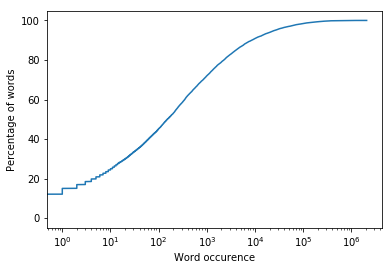

In [4]:
syns = imcount.index.tolist()

wrds = chain(*map(lambda x:tosn(x).lemma_names(), syns))
wrds = set(filter(lambda x: not ("_" in x), wrds))

x = np.sort(np.asarray(list(map(lambda x:wrdcount[x], wrds))))
y = np.arange(x.shape[0])
y = 100* y/y.max()

plt.plot(x,y)
plt.xscale("log")
plt.xlabel("Word occurence")
plt.ylabel("Percentage of words")

In [ ]:
te_selecta = lambda x:x["type"]in [2,3]
te_dist  = "train"
te_ratio = 1
te_nitems= 100
ntest = 5
res_eszsl, res_adgpm, m = [],[],[]

ranges = [(0,25), (25,50), (50,100), (100, 500), 
          (500,1000), (1000,2000), (2000,3000), 
          (3000, 5000), (5000, 10000), (10000, 50000),
          (50000, 100000)]
#ranges = [(3000,4000), (25,50), (50,100), (100, 500), 
#          (500,1000), (1000,2000), (2000,3000)]
#ranges = [(0,25), (25,100), (100, 1000), (10000, 100000)]

for x in ranges:
    dftree, dfsem = get_what(allsyns, wmin=x[0], wmax=x[1])
    tree = get_tree(dftree)
    trnodes  = set(dftree[dftree["train"]].index.tolist())
    tenodes_ = select_split(tree, te_selecta, trnodes)
    #print(x, len(trnodes), len(tenodes_))
    for i in range(ntest):
        tenodes = np.random.choice(list(tenodes_), 100, replace=False)
        eszsl = test_eszsl_sample(trnodes, tenodes, dfsem)
        adgpm = test_adgpm_sample(trnodes, tenodes)
        m.append(dftree.loc[tenodes]["lemmas"].apply(lambda x: max([wrdcount[x_] for x_ in x])).mean())
        res_eszsl.append(eszsl)
        res_adgpm.append(adgpm)

In [7]:
freq_adgpm = [x[0] for x in res_adgpm]
freq_eszsl = [x[0] for x in res_eszsl]
#plt.scatter(np.log10(m), freq_adgpm, alpha=.5)
#plt.scatter(np.log10(m), freq_eszsl, alpha=.5)

In [17]:
from scipy.stats.stats import pearsonr   
pearsonr(np.log10(m), freq_eszsl)

(0.8929226761390285, 2.9511484983175298e-18)

In [19]:
pearsonr(np.log10(m), freq_adgpm)

(0.7463138979068116, 4.937738235622482e-10)

In [22]:
#plt.scatter(np.log10(m), freq_eszsl, alpha=.5, label="GCN")

In [11]:
#wc = np.asarray([wrdcount[i] for i in wrds])

In [9]:
#lemmas = chain(*[tosn(x).lemma_names() for x in imcount.index])
#wrds = list(filter(lambda x:not("_" in x), lemmas))
#Y = [wrdcount[i] for i in wrds]
#Y = np.sort(Y)#np.log10()#[::-1]
#Y = Y[Y<10**6]
#X = np.linspace(0,100,len(Y))
#x=axes[0]

In [10]:
#x=np.asarray(list(map(lambda x:len(wn.lemmas(x)), wrds)))

In [11]:
#(x==1).mean()

NameError: name 'freq_axis' is not defined

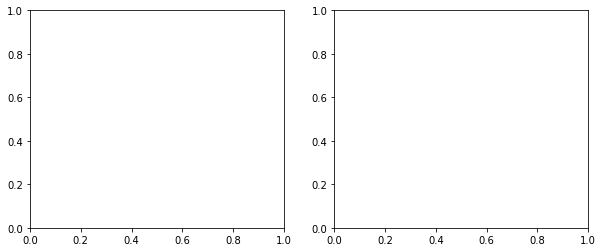

In [12]:
fig,axes = plt.subplots(1,2, figsize=(10,4))

#axes[0].plot(Y,X)
#y = [x[0] for x in res_adgpm]
#y = [x[0] for x in res_eszsl]


axes[0].scatter(freq_axis, freq_adgpm, alpha=.5, label="GCN")
axes[0].scatter(freq_axis, freq_eszsl, alpha=.5, label="Linear")
axes[0].set_xscale('log')
axes[0].set_xlabel("Mean word occurence count", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)

#axes[0].set_xscale('log')
#axes[0].set_xlabel("Word occurence count")
#axes[0].set_ylabel("Percentage of Imagenet classes")

axes[1].scatter(poly_axis, poly_adgpm, alpha=.5)#, label="GCN")
axes[1].scatter(poly_axis, poly_eszsl, alpha=.5)#, label="Linear")

axes[1].margins(.5,.2)
axes[1].set_xlabel("Meaning", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)

#fig.legend(loc="best")
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.85,0.95), fontsize=14.)
frame = legend.get_frame()
frame.set_alpha(1)
frame.set_color("#e6e6ff")

fig.savefig("./data/plots/word_factors")

In [5]:
#dftree, dfsem=get_what(synsets, wn="strict", we=None, wmin=500, wmax=1000000, imin=0, imax=10**5)
#synsets=allsyns
#wn="strict"
#we=None
#wmin=500
#wmax=1000000
#imin=0#500
#imax=10**6#10**5
#word_cond = {"min":wmin, "max":wmax, "voc":glove.isin}
#lem_cond = {}
#if we:
#    lem_cond["we"]=we
#if wn:
#   lem_cond["wn"]=wn   
#synswords = select_lemmas(synsets, lem_cond, word_cond, counter=wrdcount)
#dftree = ilsvrc_tree_df(synswords, imcount, imin, imax)
#dfsem  = ilsvrc_sem_df(synswords, glove)

#dftree, dfsem = get_what(allsyns, wmin=500, wmax=1000)
#tree = get_tree(dftree)
#trnodes  = set(dftree[dftree["train"]].index.tolist())
#tenodes_ = select_split(tree, te_selecta, trnodes)
#print(x, len(trnodes), len(tenodes_))
#tenodes = np.random.choice(list(tenodes_), 100, replace=False)
#pp(test_eszsl_sample(trnodes, tenodes, dfsem))
#pp(test_adgpm_sample(trnodes, tenodes))

#synswords.apply(lambda x:len(x)>0)
#df = pd.DataFrame({"photo": imcount, "lemmas":synswords})
#df["sem"]   = df["lemmas"].apply(lambda x:len(x)>0)
#df["lemmas"]
#synswords
#imcount
#tenodes = select_split(tree, te_selecta, trnodes)
#len(tenodes)
#s = pd.Series(x, index=tenodes)
#x = imcount.loc[tenodes].tolist()
#y = test_eszsl_perclass_acc(trnodes, tenodes, dfsem)
#plt.scatter(x,y, alpha=.5)

from zsl_newstore import *

def acc_per_class(res, lbls):
    res = (res.topk(1)[1] == lbls).long().sum(1)>0
    res = pd.Series(res.cpu().numpy(), index=lbls.squeeze().cpu().numpy())
    return res.groupby(res.index).mean().values

def test_eszsl_perclass_acc(trnodes, tenodes, df):
    v_tr = get_visu(trnodes)
    s_tr = get_sem(trnodes, df)
    v_te, s_te, l_te = get_data(tenodes, df)
    best = [0]
    out = None
    for g in [0,1,10,100, 1000]:
        for l in [0,1,10,100, 1000]:
            w = get_W(v_tr, s_tr, g, l)
            res = scores(v_te, s_te, w)
            tops = topk(res, 5, l_te)
            if tops[0]>best[0]:
                best=tops
                out=acc_per_class(res, l_te)
    return out

In [15]:
#len(dfsem), len(dftree)
#dftree.loc[dfsem.index]["lemmas"].apply()
#dftree, dfsem = get_what(allsyns, wmin=25, wmax=100)
#dftree, dfsem = get_what(allsyns, wmin=0, wmax=25)
#dftree, dfsem = get_what(allsyns, wmin=25, wmax=50)
#dftree, dfsem = get_what(allsyns, wmin=50, wmax=100)
#dftree, dfsem = get_what(allsyns, wmin=100, wmax=500)
#dftree, dfsem = get_what(allsyns, wmin=500, wmax=1000)
#dftree, dfsem = get_what(allsyns, wmin=1000, wmax=1500)
#dftree, dfsem = get_what(allsyns, wmin=1000, wmax=2000)
#dftree, dfsem = get_what(allsyns, wmin=2000, wmax=3000)

In [16]:
#print(x, pp(test_adgpm_sample(trnodes, tenodes, dfsem)))
#pp(test_adgpm_sample(trnodes, tenodes))
#res_eszsl

In [ ]:
y = [x[0] for x in res_eszsl]
plt.scatter(m, y)

# Homonimy

In [17]:
te_selecta = lambda x:x["type"]in [2,3]
te_dist   = "train"
te_ratio  = 1
te_nitems = 100
ntest = 15
res_eszsl, res_adgpm, m  = [],[],[]

#for wn in ["strict"], "very", "not_strict", "any"]:
#    for we in [None, True, False]:
for wn,we in [("strict", True), ("not_strict", False)]:
    dftree, dfsem = get_what(allsyns, we=we, wn=wn)
    tree = get_tree(dftree)
    trnodes  = set(dftree[dftree["train"]].index.tolist())
    tenodes_ = select_split(tree, te_selecta, trnodes)
    print(wn, we, len(trnodes), len(tenodes_))
    for i in range(ntest):
        tenodes = np.random.choice(list(tenodes_), 100, replace=False)
        eszsl = test_eszsl_sample(trnodes, tenodes, dfsem)
        adgpm = test_adgpm_sample(trnodes, tenodes)
        m.append((wn, we))
        res_eszsl.append(eszsl)
        res_adgpm.append(adgpm)

100%|██████████| 8890/8890 [00:31<00:00, 282.78it/s]


1964 correct lemmas. (15345 lemmas removed). 7112 synsets removed for lack of correct lemmas


82115it [00:01, 43518.55it/s]
100%|██████████| 82115/82115 [00:01<00:00, 44729.74it/s]


82115 84427 [60270, 19354, 1492, 999]
3573 3709 [255, 827, 1492, 999]


  1%|          | 10/999 [00:00<00:10, 91.05it/s]

3013 3146 [96, 426, 1492, 999]


100%|██████████| 3013/3013 [00:11<00:00, 259.84it/s]
4it [00:00, 10.48it/s]

strict True 999 1067


100it [00:03, 28.34it/s]
100it [00:00, 1527.30it/s]
100it [00:01, 66.71it/s]
100it [00:00, 1321.71it/s]
100it [00:01, 58.15it/s]
100it [00:00, 1119.90it/s]
100it [00:01, 64.58it/s]
100it [00:00, 1197.33it/s]
100it [00:00, 117.32it/s]
100it [00:00, 1507.13it/s]
100it [00:01, 85.24it/s]
100it [00:00, 1213.02it/s]
100it [00:00, 208.82it/s]
100it [00:00, 1184.61it/s]
100it [00:00, 116.68it/s]
100it [00:00, 1519.27it/s]
100it [00:00, 213.82it/s]
100it [00:00, 1530.70it/s]
100it [00:00, 123.37it/s]
100it [00:00, 1532.40it/s]
100it [00:00, 131.42it/s]
100it [00:00, 1512.93it/s]
100it [00:00, 214.27it/s]
100it [00:00, 1231.71it/s]
100it [00:00, 201.99it/s]
100it [00:00, 1218.80it/s]
100it [00:00, 208.31it/s]
100it [00:00, 1503.59it/s]
100it [00:00, 175.34it/s]
100it [00:00, 1544.36it/s]
100%|██████████| 8890/8890 [00:19<00:00, 453.94it/s]


1202 correct lemmas. (16107 lemmas removed). 7797 synsets removed for lack of correct lemmas


82115it [00:01, 44186.57it/s]
100%|██████████| 82115/82115 [00:01<00:00, 43645.04it/s]


82115 84427 [60270, 19895, 951, 999]
3023 3133 [200, 873, 951, 999]


  1%|          | 11/999 [00:00<00:09, 106.52it/s]

2485 2591 [71, 464, 951, 999]


100%|██████████| 2485/2485 [00:06<00:00, 393.87it/s]
4it [00:00, 25.56it/s]

not_strict False 999 732


100it [00:06, 14.31it/s]
100it [00:00, 1023.84it/s]
100it [00:05, 18.35it/s]
100it [00:00, 1492.26it/s]
100it [00:04, 20.17it/s]
100it [00:00, 1180.97it/s]
100it [00:04, 22.43it/s]
100it [00:00, 1541.72it/s]
100it [00:03, 27.87it/s]
100it [00:00, 1203.65it/s]
100it [00:02, 41.80it/s]
100it [00:00, 1238.00it/s]
100it [00:02, 43.98it/s]
100it [00:00, 1493.96it/s]
100it [00:01, 68.46it/s]
100it [00:00, 1123.13it/s]
100it [00:01, 60.44it/s]
100it [00:00, 1187.36it/s]
100it [00:01, 52.47it/s]
100it [00:00, 1517.84it/s]
100it [00:01, 88.56it/s]
100it [00:00, 1317.31it/s]
100it [00:01, 65.77it/s]
100it [00:00, 1551.91it/s]
100it [00:01, 81.94it/s]
100it [00:00, 1337.37it/s]
100it [00:00, 117.27it/s]
100it [00:00, 1271.93it/s]
100it [00:01, 77.52it/s]
100it [00:00, 1428.40it/s]


In [19]:
poly_adgpm = [x[0] for x in res_adgpm]
poly_eszsl = [x[0] for x in res_eszsl]
poly_axis  = ["Primary"]*15 + ["Secondary"]*15

In [147]:
tips = sns.load_dataset("tips")
#tips
x=df.iloc[[5,6,7,8,9,40,41,42,43,44]]
x.index=["primary"]*5+["secondary"]*5
#x[0].plot()#0,x.index)

In [ ]:
import seaborn as sns

df = pd.DataFrame(res_eszsl, index=m)

y1= df.iloc[5:10,0].values.tolist()
y2= df.iloc[40:45,0].values.tolist()

data={"primary":y1, "secondary":y2}

sns.catplot(x="meaning", y="accuracy", order=["primary", "secondary"], data=data)

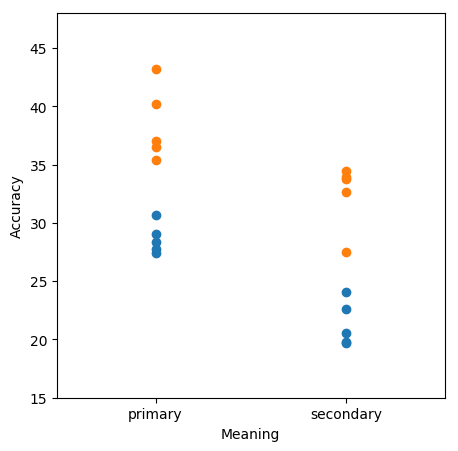

In [178]:
fig, axes = plt.subplots(1,1, figsize=(5,5))
x = ["primary"]*5 + ["secondary"]*5
df = pd.DataFrame(res_eszsl, index=m)
y1= df.iloc[5:10,0].values.tolist()
y2= df.iloc[40:45,0].values.tolist()
axes.scatter(x,y1+y2)

df = pd.DataFrame(res_adgpm, index=m)
y1= df.iloc[5:10,0].values.tolist()
y2= df.iloc[40:45,0].values.tolist()
axes.scatter(x,y1+y2)
#axes.tick_params(axis='x', pad=1)
#axes.xaxis.labelpad = 20
#fig.subplots_adjust(right=.1)#(right=-1)#, left=0)
axes.margins(.5,.2)
axes.set_xlabel("Meaning")
axes.set_ylabel("Accuracy")
fig.savefig("./data/plots/word_meaning")

In [82]:
df = pd.DataFrame(res_eszsl, index=m)
ref = {x:i for i,x in enumerate(df.index.unique().tolist())}
invref = {i:x for i,x in enumerate(df.index.unique().tolist())}
x = df.groupby(df.index.map(lambda x:ref[x])).apply(lambda x:x.mean())
x.index = x.index.map(lambda x:invref[x])
x

0          1          2          3          4
strict     NaN    27.203999  39.103998  46.965998  52.727998  57.057998
           True   28.641999  42.331998  50.609998  56.609998  61.051998
           False  27.377999  39.177998  46.463998  51.945998  55.973997
very       NaN    31.309999  43.633999  51.299998  56.727998  60.953999
           True   31.096000  44.895999  53.233999  58.931999  63.429997
           False  30.446000  43.342001  51.064000  56.518000  60.531998
not_strict NaN    23.662000  31.418000  36.371999  40.043999  43.278000
           True   23.159999  33.535999  40.963999  46.512000  50.865999
           False  21.348000  29.777999  35.381999  39.421999  42.515998
any        NaN    24.467999  34.925999  41.953999  46.863998  50.782000
           True   27.657999  40.593999  48.861999  54.663999  58.996000
           False  25.294000  35.728000  42.566000  47.786000  51.887999

In [37]:
#classacc.sort_values().plot()

In [ ]:
    df = pd.read_pickle("./data/homonimy/"+x)
    df_sem = pd.read_pickle("./data/homonimy/"+x+"_sem")
    df["word_ok"]=df["sem"]
    df["image"]=True
    tree = WnTree(df)
    tree = tree.prune_empty_branches()
    tree = tree.prune_dummy_nodes()
    print(len(tree.nodes), len(tree.edges), count_tpe(tree))
    trnodes = set(df[df["train"]].index.tolist())
    tenodes_ = select_split(tree, te_selecta, trnodes)
    print(len(tenodes_))
    
    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(x, pp(test_class(trnodes, tenodes, df_sem)))
    print(x, pp(test_sample(trnodes, tenodes, df_sem)))
    
    tenodes = np.random.choice(list(tenodes_), 100, replace=False)
    print(x, pp(test_class(trnodes, tenodes, df_sem)))
    print(x, pp(test_sample(trnodes, tenodes, df_sem)))

# Lemma scarcity

In [5]:
te_selecta = lambda x:x["type"]in [2,3]
te_dist  = "train"
te_ratio = 1
te_nitems= 100

for x in [10, 100, 1000, 10000]:
    df = pd.read_pickle("./data/lemma_count/df_{}".format(x))
    df_sem = pd.read_pickle("./data/lemma_count/df_{}_sem".format(x))
    df["word_ok"]=df["sem"]
    df["image"]=True
    tree = WnTree(df)
    tree = tree.prune_empty_branches()
    tree = tree.prune_dummy_nodes()
    print(len(tree.nodes), len(tree.edges), count_tpe(tree))
    
    trnodes = set(df[df["train"]].index.tolist())
    tenodes_ = select_split(tree, te_selecta, trnodes)
    print(len(tenodes_))

    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(x, pp(test_class(trnodes, tenodes, df_sem)))
    print(x, pp(test_sample(trnodes, tenodes, df_sem)))
    
    tenodes = np.random.choice(list(tenodes_), 100, replace=False)
    print(x, pp(test_class(trnodes, tenodes, df_sem)))
    print(x, pp(test_sample(trnodes, tenodes, df_sem)))

82115it [00:03, 24205.30it/s]
  2%|▏         | 17/1000 [00:00<00:05, 168.41it/s]

3035 3157 [135, 607, 1293, 1000]


100%|██████████| 3035/3035 [00:07<00:00, 432.97it/s]


1152


100%|██████████| 3035/3035 [00:00<00:00, 537050.70it/s]
3035it [00:00, 86731.21it/s]
8it [00:00, 65.49it/s]

10  31.00 | 41.00 | 44.00 | 54.00 | 57.00 


100it [00:01, 59.89it/s]


10  18.97 | 26.90 | 32.75 | 37.45 | 41.18 


9it [00:00, 76.48it/s]

10  21.00 | 27.00 | 34.00 | 35.00 | 40.00 


100it [00:01, 58.92it/s]
10225it [00:00, 102238.88it/s]

10  12.78 | 19.98 | 25.32 | 29.30 | 32.37 


82115it [00:00, 102118.62it/s]
  1%|          | 11/1000 [00:00<00:09, 104.69it/s]

4810 5006 [261, 756, 2793, 1000]


100%|██████████| 4810/4810 [00:22<00:00, 209.15it/s]


2396


100%|██████████| 4810/4810 [00:00<00:00, 550556.77it/s]
4810it [00:00, 106649.69it/s]
13it [00:00, 123.69it/s]

100  42.00 | 49.00 | 59.00 | 64.00 | 66.00 


100it [00:01, 82.74it/s]


100  22.15 | 34.00 | 41.05 | 46.16 | 49.91 


15it [00:00, 65.59it/s]

100  31.00 | 39.00 | 45.00 | 49.00 | 54.00 


100it [00:01, 91.06it/s]
10175it [00:00, 101738.45it/s]

100  19.07 | 28.12 | 34.24 | 38.82 | 41.99 


82115it [00:00, 101186.17it/s]
  2%|▏         | 15/1000 [00:00<00:06, 143.52it/s]

3411 3573 [173, 548, 1690, 1000]


100%|██████████| 3411/3411 [00:09<00:00, 364.49it/s]


1346


100%|██████████| 3411/3411 [00:00<00:00, 560215.01it/s]
3411it [00:00, 92650.83it/s]
100it [00:00, 711.01it/s]

1000  40.00 | 54.00 | 59.00 | 66.00 | 69.00 


1000  24.50 | 37.07 | 44.13 | 49.08 | 53.38 


31it [00:00, 268.00it/s]

1000  38.00 | 48.00 | 51.00 | 55.00 | 55.00 


100it [00:00, 226.99it/s]
10199it [00:00, 101973.32it/s]

1000  20.44 | 29.41 | 35.14 | 39.32 | 42.82 


82115it [00:00, 103989.87it/s]
  2%|▎         | 25/1000 [00:00<00:04, 240.15it/s]

2065 2177 [95, 375, 595, 1000]


100%|██████████| 2065/2065 [00:01<00:00, 1234.67it/s]


399


100%|██████████| 2065/2065 [00:00<00:00, 612188.14it/s]
2065it [00:00, 83425.52it/s]
33it [00:00, 311.65it/s]

10000  39.00 | 43.00 | 50.00 | 55.00 | 56.00 


100it [00:00, 349.65it/s]


10000  21.37 | 28.75 | 34.02 | 37.80 | 40.91 


24it [00:00, 203.58it/s]

10000  30.00 | 34.00 | 41.00 | 46.00 | 50.00 


100it [00:00, 285.71it/s]


10000  16.83 | 23.92 | 29.74 | 34.10 | 38.12 


# Image count

In [6]:
te_selecta = lambda x:x["type"]in [2,3]
te_dist  = "train"
te_ratio = 1
te_nitems= 100

for x in [0, 10, 100, 1000]:
    df = pd.read_pickle("./data/image_count/df_{}".format(x))
    df_sem = pd.read_pickle("./data/image_count/df_{}_sem".format(x))
    df["word_ok"]=df["sem"]
    df["image"]=True
    
    tree = WnTree(df)
    tree = tree.prune_empty_branches()
    tree = tree.prune_dummy_nodes()
    print(len(tree.nodes), len(tree.edges), count_tpe(tree))
    
    trnodes = set(df[df["train"]].index.tolist())
    tenodes_ = select_split(tree, te_selecta, trnodes)
    print(len(tenodes_))
    
    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(x, pp(test_class(trnodes, tenodes, df_sem)))
    print(x, pp(test_sample(trnodes, tenodes, df_sem)))
    
    tenodes = np.random.choice(list(tenodes_), 100, replace=False)
    print(x, pp(test_class(trnodes, tenodes, df_sem)))
    print(x, pp(test_sample(trnodes, tenodes, df_sem)))

82115it [00:00, 103159.15it/s]
  3%|▎         | 32/1000 [00:00<00:03, 319.05it/s]

1635 1726 [62, 421, 152, 1000]


100%|██████████| 1635/1635 [00:00<00:00, 3623.38it/s]


143


100%|██████████| 1635/1635 [00:00<00:00, 631986.64it/s]
1635it [00:00, 76582.84it/s]
14it [00:00, 131.04it/s]

0  20.00 | 27.00 | 28.00 | 31.00 | 34.00 


100it [00:00, 105.73it/s]


0  11.25 | 15.25 | 19.25 | 22.25 | 24.50 


33it [00:00, 320.17it/s]

0  16.00 | 22.00 | 26.00 | 29.00 | 34.00 


100it [00:00, 354.86it/s]
10331it [00:00, 103295.81it/s]

0  10.80 | 15.73 | 20.42 | 23.24 | 27.70 


82115it [00:00, 105842.07it/s]
  3%|▎         | 26/1000 [00:00<00:03, 255.82it/s]

1912 2006 [92, 468, 352, 1000]


100%|██████████| 1912/1912 [00:01<00:00, 1463.12it/s]


336


100%|██████████| 1912/1912 [00:00<00:00, 609292.60it/s]
1912it [00:00, 75491.23it/s]
11it [00:00, 104.23it/s]

10  19.00 | 27.00 | 33.00 | 36.00 | 39.00 


100it [00:01, 94.30it/s]


10  9.11 | 15.46 | 20.00 | 24.34 | 27.53 


14it [00:00, 138.84it/s]

10  16.00 | 19.00 | 23.00 | 23.00 | 27.00 


100it [00:00, 106.06it/s]
10170it [00:00, 101684.34it/s]

10  7.11 | 11.25 | 14.84 | 17.51 | 19.86 


82115it [00:00, 104384.46it/s]
  2%|▏         | 16/1000 [00:00<00:06, 158.06it/s]

2985 3129 [170, 564, 1251, 1000]


100%|██████████| 2985/2985 [00:06<00:00, 438.45it/s]


1082


100%|██████████| 2985/2985 [00:00<00:00, 566977.51it/s]
2985it [00:00, 88450.54it/s]
100it [00:00, 758.10it/s]

100  32.00 | 47.00 | 57.00 | 61.00 | 61.00 


100  18.10 | 29.11 | 35.87 | 40.88 | 44.05 


36it [00:00, 345.32it/s]

100  26.00 | 32.00 | 42.00 | 49.00 | 51.00 


100it [00:00, 299.46it/s]
10242it [00:00, 102404.47it/s]

100  15.73 | 24.04 | 29.49 | 33.57 | 36.56 


82115it [00:00, 102914.95it/s]
  2%|▏         | 16/1000 [00:00<00:06, 156.27it/s]

3252 3406 [154, 438, 1660, 1000]


100%|██████████| 3252/3252 [00:07<00:00, 428.00it/s]


1200


100%|██████████| 3252/3252 [00:00<00:00, 570443.59it/s]
3252it [00:00, 92381.05it/s]
100it [00:00, 1764.48it/s]

1000  46.00 | 62.00 | 69.00 | 76.00 | 81.00 


1000  27.46 | 41.39 | 49.21 | 54.97 | 59.37 


38it [00:00, 370.71it/s]

1000  43.00 | 55.00 | 62.00 | 67.00 | 73.00 


100it [00:00, 463.05it/s]


1000  26.53 | 37.04 | 43.29 | 48.05 | 52.21 


In [10]:
#print(x, pp(test_class(trnodes, tenodes, df_sem)))
#print(x, pp(test_sample(trnodes, tenodes, df_sem)))

In [7]:
te_dist   = "train"
te_ratio  = 1
te_nitems = 100
tenodes   = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)

100%|██████████| 3252/3252 [00:00<00:00, 580247.44it/s]
3252it [00:00, 93384.16it/s]


In [8]:
te_dist   = "train"
te_ratio  = 1
te_nitems = 100
tenodes   = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)

for te_ratio in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(te_ratio, pp(test_class(trnodes, tenodes, df_sem)))
    print(te_ratio, pp(test_sample(trnodes, tenodes, df_sem)))

100%|██████████| 3252/3252 [00:00<00:00, 558782.33it/s]
3252it [00:00, 120397.89it/s]
100it [00:00, 1018.71it/s]

0  42.00 | 54.00 | 63.00 | 68.00 | 69.00 


0  21.95 | 30.20 | 36.07 | 40.67 | 44.41 


100%|██████████| 3252/3252 [00:00<00:00, 542988.72it/s]
3252it [00:00, 113304.01it/s]
100it [00:00, 2737.76it/s]

0.2  43.00 | 57.00 | 63.00 | 70.00 | 70.00 


0.2  21.54 | 30.00 | 36.56 | 41.53 | 45.12 


100%|██████████| 3252/3252 [00:00<00:00, 567052.32it/s]
3252it [00:00, 109202.88it/s]
100it [00:00, 1778.51it/s]

0.4  38.00 | 49.00 | 56.00 | 62.00 | 66.00 


0.4  18.45 | 27.15 | 34.08 | 40.20 | 45.04 


100%|██████████| 3252/3252 [00:00<00:00, 585101.09it/s]
3252it [00:00, 101710.43it/s]
100it [00:00, 2751.34it/s]

0.6  44.00 | 53.00 | 61.00 | 69.00 | 70.00 


0.6  19.18 | 28.78 | 35.36 | 40.67 | 45.10 


100%|██████████| 3252/3252 [00:00<00:00, 591289.95it/s]
3252it [00:00, 98685.94it/s]
100it [00:00, 2743.04it/s]

0.8  47.00 | 60.00 | 67.00 | 74.00 | 74.00 


0.8  21.25 | 33.06 | 41.03 | 46.78 | 51.17 


100%|██████████| 3252/3252 [00:00<00:00, 577300.40it/s]
3252it [00:00, 92598.04it/s]
100it [00:00, 2726.32it/s]

1  46.00 | 62.00 | 69.00 | 76.00 | 81.00 


1  27.46 | 41.39 | 49.21 | 54.97 | 59.37 


In [63]:
te_dist  = "train"
te_ratio = 1
te_nitems= 100

for te_ratio in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(te_ratio, pp(test(trnodes, tenodes)))

100%|██████████| 4659/4659 [00:00<00:00, 558433.47it/s]
4659it [00:00, 138360.89it/s]
100it [00:00, 2881.02it/s]


0  25.75 | 35.85 | 41.66 | 46.08 | 50.05 


100%|██████████| 4659/4659 [00:00<00:00, 534761.71it/s]
4659it [00:00, 136109.65it/s]
100it [00:00, 2837.75it/s]


0.2  24.34 | 34.83 | 42.02 | 47.82 | 51.92 


100%|██████████| 4659/4659 [00:00<00:00, 551545.65it/s]
4659it [00:00, 123460.87it/s]
100it [00:00, 2817.98it/s]


0.4  24.58 | 35.71 | 42.80 | 48.45 | 52.44 


100%|██████████| 4659/4659 [00:00<00:00, 427598.74it/s]
4659it [00:00, 88744.86it/s]
100it [00:00, 2555.76it/s]


0.6  27.58 | 39.10 | 46.54 | 52.07 | 56.17 


100%|██████████| 4659/4659 [00:00<00:00, 528585.09it/s]
4659it [00:00, 112262.88it/s]
100it [00:00, 2779.16it/s]


0.8  30.63 | 44.25 | 51.68 | 56.77 | 60.84 


100%|██████████| 4659/4659 [00:00<00:00, 547911.46it/s]
4659it [00:00, 106325.60it/s]
100it [00:00, 2684.96it/s]


1  39.02 | 54.11 | 61.58 | 67.37 | 71.08 


In [64]:
#test(trnodes, tenodes)

In [10]:
te_dist  = "all"#"tmp"
te_ratio = 1
te_nitems= 1000
#
#df.columns
tr_selecta = lambda x:x["type"]==3
te_selecta = lambda x:x["type"]in [2,3]

In [8]:
trnodes = set(df[df["train"]].index.tolist())
tenodes_ = select_split(tree, te_selecta, trnodes)

100%|██████████| 4659/4659 [00:44<00:00, 103.74it/s]


In [9]:
te_dist  = "train"
te_ratio = 1
tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
len(tenodes_), len(tenodes)

100%|██████████| 4659/4659 [00:00<00:00, 229845.83it/s]
4659it [00:00, 19317.45it/s]


(2203, 1000)

# Evaluate distributions

In [15]:
te_dist  = "train"
te_ratio = 1
te_nitems= 1000

for te_ratio in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(te_ratio, pp(test(trnodes, tenodes)))

100%|██████████| 4659/4659 [00:00<00:00, 197014.35it/s]
4659it [00:00, 12677.43it/s]


0  17.80 | 25.40 | 29.90 | 32.80 | 35.80 


100%|██████████| 4659/4659 [00:00<00:00, 216298.40it/s]
4659it [00:00, 12541.00it/s]


0.2  24.30 | 34.50 | 40.60 | 45.90 | 49.50 


100%|██████████| 4659/4659 [00:00<00:00, 205810.15it/s]
4659it [00:00, 14636.59it/s]


0.4  27.40 | 39.60 | 47.30 | 51.50 | 55.60 


100%|██████████| 4659/4659 [00:00<00:00, 211666.49it/s]
4659it [00:00, 16069.76it/s]


0.6  28.20 | 39.90 | 46.90 | 52.40 | 57.20 


100%|██████████| 4659/4659 [00:00<00:00, 178996.82it/s]
4659it [00:00, 17051.83it/s]


0.8  28.00 | 41.00 | 48.20 | 53.70 | 57.40 


100%|██████████| 4659/4659 [00:00<00:00, 229986.49it/s]
4659it [00:00, 19229.04it/s]


1  25.70 | 38.40 | 45.50 | 50.90 | 54.70 


In [ ]:
te_dist  = "train"
te_ratio = 1
te_nitems= 1000

for te_nitems in [200, 500, 1000, 1500, 2000]:
    tenodes  = select_subset(tree, tenodes_, te_dist, te_nitems, te_ratio)
    print(te_nitems, pp(test(trnodes, tenodes)))